In [16]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [17]:
# Load files into a pandas dataframe
train = pd.read_csv('/kaggle/input/financial-inclusion-in-africa/Train.csv')
test = pd.read_csv('/kaggle/input/financial-inclusion-in-africa/Test.csv')
#ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('/kaggle/input/financial-inclusion-in-africa/VariableDefinitions.csv')

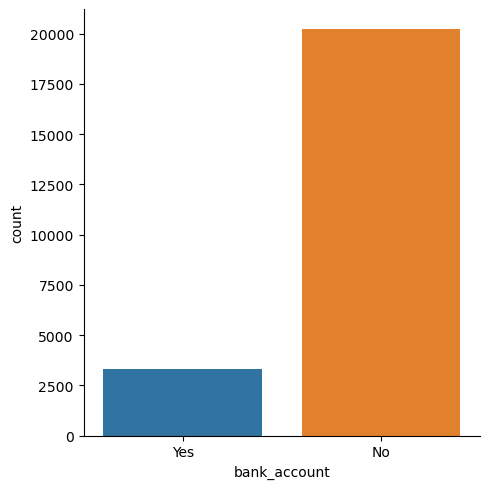

In [18]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [19]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Cobvert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [20]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    #data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    data['relationship_with_head']=data['relationship_with_head'].replace({'Head of Household':0,'Spouse':1,'Child':2,'Parent':3,'Other relative':4,'Other non-relatives':5})
    data['marital_status']=data['marital_status'].replace({'Married/Living together':0,'Single/Never Married':1,'Widowed':2,'Divorced/Seperated':3,'Dont know':4})
    data['education_level']=data['education_level'].replace({'Primary education':0,'No formal education':1,'Secondary education':2,'Tertiary education':3,'Vocational/Specialised training':4,'Other/Dont know/RTA':5})
    data['job_type']=data['job_type'].replace({'Self employed':0,'Informally employed':1,'Farming and Fishing':2,'Remittance Dependent':3,'Other Income':4,'Formally employed Private':5,'No Income':6,'Formally employed Government':7,'Government Dependent':8,'Dont Know/Refuse to answer':9})
    data['country']=data['country'].replace({'Rwanda':0,'Tanzania':1,'Kenya':2,'Uganda':3})

    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

In [21]:
#X_train.drop('uniqueid', axis=1, inplace=True)


In [22]:
# preprocess the train data 

processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

In [23]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.2, random_state=42)

In [24]:
from catboost import CatBoostClassifier

# Create CatBoost classifier model
cat_model = CatBoostClassifier()

# Fit the model to the training data
cat_model.fit(X_Train, y_Train)


Learning rate set to 0.036073
0:	learn: 0.6600430	total: 58.4ms	remaining: 58.4s
1:	learn: 0.6299437	total: 64ms	remaining: 31.9s
2:	learn: 0.5984427	total: 68.6ms	remaining: 22.8s
3:	learn: 0.5726148	total: 73.6ms	remaining: 18.3s
4:	learn: 0.5504492	total: 78.8ms	remaining: 15.7s
5:	learn: 0.5266951	total: 83.7ms	remaining: 13.9s
6:	learn: 0.5074326	total: 88.6ms	remaining: 12.6s
7:	learn: 0.4928848	total: 92.4ms	remaining: 11.5s
8:	learn: 0.4760380	total: 98.3ms	remaining: 10.8s
9:	learn: 0.4650678	total: 102ms	remaining: 10.1s
10:	learn: 0.4515839	total: 107ms	remaining: 9.65s
11:	learn: 0.4402021	total: 113ms	remaining: 9.27s
12:	learn: 0.4297268	total: 117ms	remaining: 8.9s
13:	learn: 0.4194143	total: 122ms	remaining: 8.6s
14:	learn: 0.4091709	total: 127ms	remaining: 8.36s
15:	learn: 0.3988762	total: 132ms	remaining: 8.12s
16:	learn: 0.3899134	total: 137ms	remaining: 7.94s
17:	learn: 0.3827700	total: 142ms	remaining: 7.76s
18:	learn: 0.3780281	total: 146ms	remaining: 7.55s
19:	le

In [25]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
cat_y = cat_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, cat_y))

Error rate of XGB classifier:  0.11243358129649306


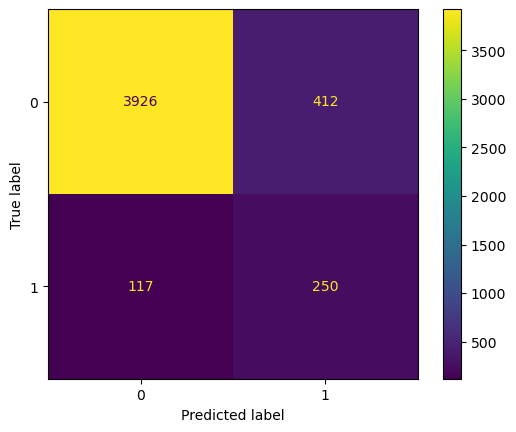

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
clf=cat_model
cm = confusion_matrix(cat_y, y_val, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Create CatBoost classifier model
cat_model = CatBoostClassifier()

# Define the parameter grid for grid search
param_grid = {
    'depth': [3, 5, 7],  # Different depth values to try
    'learning_rate': [0.1, 0.01, 0.001],  # Different learning rate values to try
    'iterations': [100, 200, 300]  # Different number of iterations to try
}

# Perform grid search
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the best model to the training data
best_model.fit(X_train, y_train)


ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'uniqueid_4324'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2341, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2222, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1438, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 792, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1419, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3955, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4005, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3821, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2787, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="uniqueid_4324": Cannot convert 'b'uniqueid_4324'' to float

--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'uniqueid_1'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5131, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2341, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2222, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1438, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 792, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1419, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3955, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4005, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3821, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2787, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=2]="uniqueid_1": Cannot convert 'b'uniqueid_1'' to float


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = cat_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

In [ ]:
# Get the predicted result for the test Data
test.bank_account = cat_model.predict(processed_test)

In [ ]:
# Create submission DataFrame
test1=pd.read_csv('/kaggle/input/financial-inclusion-in-africa/Test.csv')
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test1["country"],
                           "bank_account": test.bank_account})

In [ ]:
# Create submission csv file csv file
submission.to_csv('submission4.csv', index = False)
#files.download('first_submission.csv') 